# Generate training dataset for Proxy (from AAlpha submission data)



In [1]:
# Libraries

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
from google.cloud import storage
import matplotlib.pyplot as plt
import requests


In [2]:
aalpha_data = "/mnt/user_storage/atlas_data/metadata-rc2.parquet"  # final Aug 30.18h (+ Unifold)

In [3]:
# We can reuse original_df to reset the data
df = pd.read_parquet(aalpha_data)

print(f"Loaded Dataframe with {len(df)} rows! Enjoy!")

Loaded Dataframe with 773846840 rows! Enjoy!


In [4]:
df.head()

,id,is_fragment,sequenceChecksum,ptm,plddt,num_conf,len,esmfold_version,atlas_version,sequence_dbs
0,MGYP000000077819,True,99294480DA1FB30C,0.160,0.502,0,56,v0,v0,"MGnify90_2022_05,MGnify90_2023_02"
1,MGYP000000115080,True,9BC000D98280FA56,0.345,0.520,51,298,v0,v0,"MGnify90_2022_05,MGnify90_2023_02"
2,MGYP000000184299,False,4ED4804801E0A9DF,0.875,0.942,260,269,v0,v0,"MGnify90_2022_05,MGnify90_2023_02"
3,MGYP000000249471,True,DC7604ABAE9150F5,0.440,0.868,248,286,v0,v0,"MGnify90_2022_05,MGnify90_2023_02"
4,MGYP000000315598,True,9E61310D4D3158EC,0.869,0.868,332,404,v0,v0,"MGnify90_2022_05,MGnify90_2023_02"


In [5]:
df_small = df[df['len'] < 200]

In [ ]:
df_small = df_small[df_small['esmfold_version'] == 'v1']

KeyboardInterrupt: 

In [26]:
a, b = np.histogram(df_small['ptm'],bins=50)

c = np.digitize(df_small['ptm'], bins=b)

invw = np.zeros_like(c)

for i in range(len(c)):
    #rint(c[i] - 1)
    if c[i] == 51: 
        invw[i] = a[c[i] - 2]
    else:
        invw[i] = a[c[i] - 1]

In [53]:
# Number of samples to keep
n_samples = 100_000

# Fractions for splitting
train_frac, test_frac, valid_frac = 0.7, 0.2, 0.1

n_train = int(n_samples * train_frac)
n_test = int(n_samples * test_frac)
n_valid = int(n_samples * valid_frac)

train_data = df_small.sample(n=n_train, weights=1/invw)
test_data = df_small.sample(n=n_test, weights=1/invw)
valid_data = df_small.sample(n=n_valid, weights=1/invw)

train_data["split"] = "train"
test_data["split"] = "test"
valid_data["split"] = "validation"

dataset = pd.concat([train_data, test_data, valid_data])

Actual Fractions: train, test, valid 0.00, 0.00, 0.00


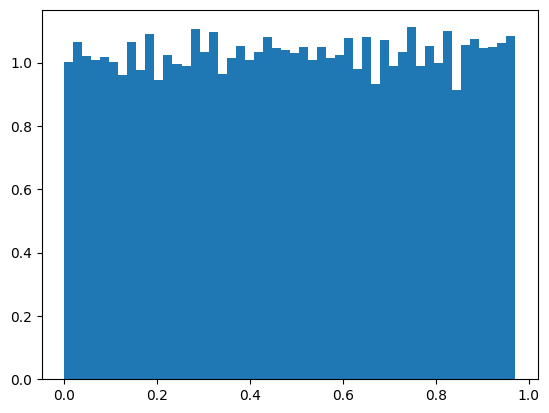

In [55]:
# Verify our PTM follows a uniform histogram
plt.hist(dataset['ptm'], bins=50, density=True);

In [ ]:
sequences = []
for i in range(len(dataset)):
    response = requests.get(f"https://api.esmatlas.com/fetchSequence/{dataset['id'][i]}", verify=False)
    sequences.append(response.text[14:-2])
    
dataset["sequence"] = sequences

In [56]:
save_bucket_name = "casual-storage"
save_gcs_dir = "aalpha"

suffix = f"v0"

# Getting the current date and time and formatting it as YYYYMMDD
current_date = datetime.now().strftime("%Y%m%d%HH%SS")

# Saving the dataset with the current date in the filename
dataset_filename = f"atlas_dataset_{suffix}_{current_date}"

# Creating and saving an info file
info_data = """
This dataset was generated on {date_info}.
This dataset was built based on aalpha data @ {aalpha_data}.

We filtered out the data folded from unifold & afm.
We split data to keep distribution of dockq scores.
""".format(
    date_info=current_date,
    aalpha_data=aalpha_data,
)

print(f"Save dataset with name: {dataset_filename}\n&info:\n{info_data}")
print(f"Save data @ gs://{save_bucket_name}/{save_gcs_dir}")


# Save query 
storage_client = storage.Client()
bucket = storage_client.bucket(save_bucket_name)
blob = bucket.blob(f"{save_gcs_dir}/{dataset_filename}_info.txt")
blob.upload_from_string(info_data)

# Save dataframe!
dataset.to_csv(f"gs://{save_bucket_name}/{save_gcs_dir}/{dataset_filename}.csv", index=False)

Save dataset with name: atlas_dataset_v0_2023111009H29S
&info:

This dataset was generated on 2023111009H29S.
This dataset was built based on aalpha data @ /mnt/user_storage/atlas_data/metadata-rc2.parquet.

We filtered out the data folded from unifold & afm.
We split data to keep distribution of dockq scores.

Save data @ gs://casual-storage/aalpha
